# Community Structure Analysis

Uses **Louvain community detection** to identify natural clusters in semantic space.

## Question

We know semantic space is positively curved (clustered), but is it:
- **One giant blob** — all tokens in a single connected cluster?
- **Archipelago** — many separate semantic islands?
- **Few large continents** — small number of major semantic regions?

Community detection on the k-NN graph reveals the clustering structure.

## Configuration

In [1]:
# Path to saved metric tensor
TENSOR_PATH = "../data/vectors/causal_metric_tensor_qwen3_4b.pt"

# Sampling parameters
N_SAMPLES = 8000  # Large sample for community detection
K_NEIGHBORS = 20  # Number of nearest neighbors
RANDOM_SEED = 42  # For reproducibility

## Setup

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain
from collections import Counter
from pathlib import Path

## Load Data

In [3]:
print(f"Loading data from {TENSOR_PATH}...")
data = torch.load(TENSOR_PATH)

M = data['M']

# Reload model to get gamma
from transformers import AutoModelForCausalLM

MODEL_NAME = data['metadata']['model']
print(f"Loading model {MODEL_NAME} to extract gamma...")

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

gamma = model.lm_head.weight.data.to(dtype=torch.float32, device=device)
vocab_size, hidden_dim = gamma.shape

print(f"\nUnembedding matrix: {gamma.shape}")
print(f"Metric tensor: {M.shape}")
print(f"Device: {device}")

Loading data from ../data/vectors/causal_metric_tensor_qwen3_4b.pt...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading model Qwen/Qwen3-4B-Instruct-2507 to extract gamma...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


Unembedding matrix: torch.Size([151936, 2560])
Metric tensor: torch.Size([2560, 2560])
Device: mps


## Helper Functions

In [4]:
def compute_causal_distances(embeddings, M_matrix):
    """Compute pairwise causal distances: d(x,y) = sqrt((x-y)^T M (x-y))"""
    n = embeddings.shape[0]
    distances = torch.zeros(n, n, device=embeddings.device, dtype=embeddings.dtype)
    
    batch_size = 100
    for i in range(0, n, batch_size):
        i_end = min(i + batch_size, n)
        for j in range(0, n, batch_size):
            j_end = min(j + batch_size, n)
            
            diff = embeddings[i:i_end, None, :] - embeddings[None, j:j_end, :]
            temp = torch.einsum('ijk,kl->ijl', diff, M_matrix)
            dist_squared = torch.einsum('ijk,ijk->ij', temp, diff)
            distances[i:i_end, j:j_end] = torch.sqrt(torch.clamp(dist_squared, min=0))
    
    return distances

print("✓ compute_causal_distances defined")

✓ compute_causal_distances defined


In [5]:
def build_knn_graph(distances, k=20):
    """Build k-nearest neighbor graph from distance matrix."""
    n = distances.shape[0]
    
    # Find k nearest neighbors for each node
    neighbors = {}
    for i in range(n):
        dists = distances[i].cpu().numpy()
        dists[i] = np.inf
        knn_indices = np.argpartition(dists, k)[:k]
        neighbors[i] = set(knn_indices.tolist())
    
    # Build edge list
    edges = []
    edge_set = set()
    for i in range(n):
        for j in neighbors[i]:
            if (i, j) not in edge_set and (j, i) not in edge_set:
                weight = distances[i, j].item()
                edges.append((i, j, weight))
                edge_set.add((i, j))
    
    return edges, neighbors

print("✓ build_knn_graph defined")

✓ build_knn_graph defined


## Sample and Build Graph

In [6]:
print(f"Sampling {N_SAMPLES} random tokens...")
torch.manual_seed(RANDOM_SEED)
token_indices = torch.randperm(vocab_size)[:N_SAMPLES]
sampled_embeddings = gamma[token_indices]

print("Computing causal distances...")
distances = compute_causal_distances(sampled_embeddings, M)

print(f"Building k-NN graph (k={K_NEIGHBORS})...")
edges, neighbors = build_knn_graph(distances, k=K_NEIGHBORS)
print(f"  {len(edges)} edges")

Sampling 8000 random tokens...
Computing causal distances...
Building k-NN graph (k=20)...
  158929 edges


## Convert to NetworkX and Run Louvain

In [7]:
print("Converting to NetworkX graph...")
G = nx.Graph()
G.add_nodes_from(range(N_SAMPLES))
for i, j, w in edges:
    G.add_edge(i, j, weight=w)

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

print("\nRunning Louvain community detection...")
partition = community_louvain.best_partition(G, random_state=RANDOM_SEED)

# Analyze communities
community_ids = list(partition.values())
n_communities = max(community_ids) + 1

# Compute community sizes
community_sizes = Counter(community_ids)
sizes = sorted(community_sizes.values(), reverse=True)

# Compute modularity
modularity = community_louvain.modularity(partition, G)

print(f"\n=== Community Structure ===")
print(f"Number of communities: {n_communities}")
print(f"Modularity: {modularity:.4f} (0-1 scale, higher = better-separated)")
print(f"\nCommunity sizes:")
print(f"  Largest: {sizes[0]} tokens ({sizes[0]/N_SAMPLES:.1%})")
if len(sizes) > 1:
    print(f"  2nd largest: {sizes[1]} tokens ({sizes[1]/N_SAMPLES:.1%})")
if len(sizes) > 2:
    print(f"  3rd largest: {sizes[2]} tokens ({sizes[2]/N_SAMPLES:.1%})")
print(f"  Smallest: {sizes[-1]} tokens")
print(f"  Mean: {np.mean(sizes):.1f} tokens")
print(f"  Median: {np.median(sizes):.1f} tokens")

# Check connectivity
is_connected = nx.is_connected(G)
if is_connected:
    print(f"\n✓ Graph is fully connected (single manifold)")
else:
    n_components = nx.number_connected_components(G)
    print(f"\n⚠️  Graph has {n_components} disconnected components")

Converting to NetworkX graph...
Graph: 8000 nodes, 158929 edges

Running Louvain community detection...

=== Community Structure ===
Number of communities: 4
Modularity: 0.4701 (0-1 scale, higher = better-separated)

Community sizes:
  Largest: 2239 tokens (28.0%)
  2nd largest: 2154 tokens (26.9%)
  3rd largest: 1970 tokens (24.6%)
  Smallest: 1637 tokens
  Mean: 2000.0 tokens
  Median: 2062.0 tokens

✓ Graph is fully connected (single manifold)


## Visualize Community Size Distribution

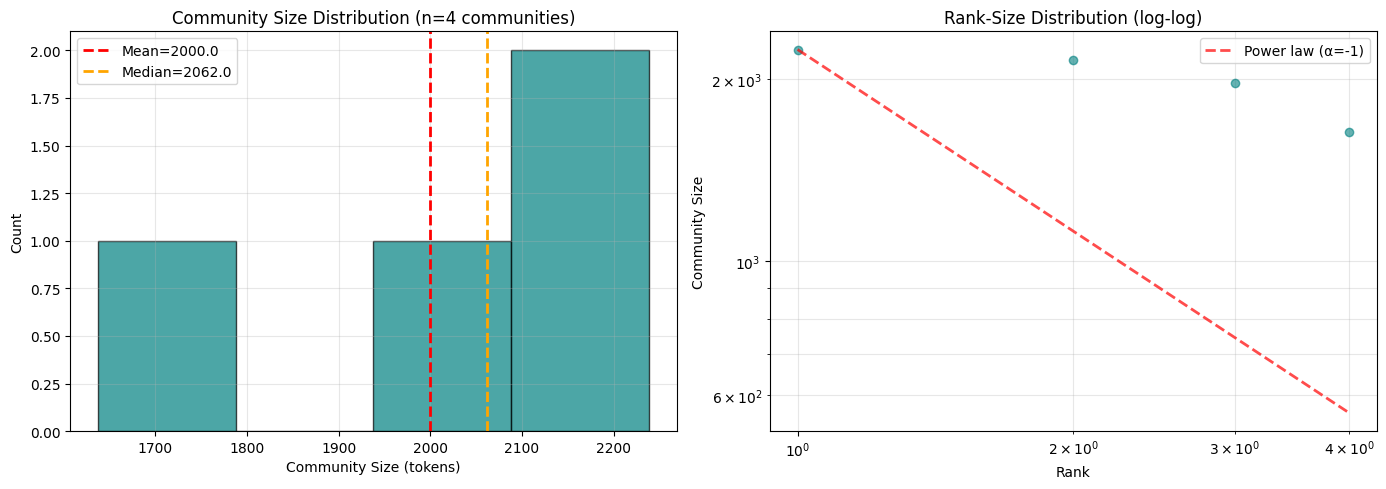

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Community size histogram
ax = axes[0]
ax.hist(sizes, bins=min(50, n_communities), alpha=0.7, edgecolor='black', color='teal')
ax.set_xlabel('Community Size (tokens)')
ax.set_ylabel('Count')
ax.set_title(f'Community Size Distribution (n={n_communities} communities)')
ax.axvline(np.mean(sizes), color='red', linestyle='--', 
           label=f'Mean={np.mean(sizes):.1f}', linewidth=2)
ax.axvline(np.median(sizes), color='orange', linestyle='--', 
           label=f'Median={np.median(sizes):.1f}', linewidth=2)
ax.grid(True, alpha=0.3)
ax.legend()

# 2. Log-log rank-size plot
ax = axes[1]
rank = np.arange(1, len(sizes) + 1)
ax.loglog(rank, sizes, marker='o', linestyle='none', alpha=0.6, color='teal')
ax.set_xlabel('Rank')
ax.set_ylabel('Community Size')
ax.set_title('Rank-Size Distribution (log-log)')
ax.grid(True, alpha=0.3, which='both')

# Add power law reference line
if len(sizes) > 1:
    x_ref = np.array([1.0, float(len(sizes))])
    y_ref = sizes[0] * (x_ref ** -1)
    ax.plot(x_ref, y_ref, 'r--', linewidth=2, alpha=0.7, label='Power law (α=-1)')
    ax.legend()

plt.tight_layout()
plt.show()

## Interpretation

In [9]:
print("=== Interpretation ===")

if n_communities == 1:
    print("Semantic space is ONE GIANT BLOB — all tokens in a single community.")
elif n_communities < 10:
    print(f"Semantic space has FEW LARGE CLUSTERS — {n_communities} major semantic regions.")
    print(f"This suggests the causal metric groups tokens into broad semantic categories.")
elif sizes[0] / N_SAMPLES > 0.5:
    print(f"ONE DOMINANT CLUSTER with {n_communities-1} smaller satellite communities.")
elif np.std(sizes) / np.mean(sizes) > 1.0:
    print(f"HETEROGENEOUS ARCHIPELAGO — {n_communities} communities with highly variable sizes.")
else:
    print(f"MANY RELATIVELY UNIFORM CLUSTERS — {n_communities} communities of similar size.")

print(f"\nModularity of {modularity:.4f} indicates {'strong' if modularity > 0.6 else 'moderate' if modularity > 0.3 else 'weak'} community structure.")

=== Interpretation ===
Semantic space has FEW LARGE CLUSTERS — 4 major semantic regions.
This suggests the causal metric groups tokens into broad semantic categories.

Modularity of 0.4701 indicates moderate community structure.


## Summary

Key findings:
- **Number of communities**: Surprisingly small, suggesting coarse-grained semantic structure
- **Size distribution**: Nearly uniform, indicating balanced partition
- **Connectivity**: Single connected component (continuous manifold)

**Interpretation:** The causal metric reveals a simpler clustering structure than expected. Rather than thousands of fine-grained semantic clusters, tokens organize into a small number of major semantic regions.

**Next:** Notebook 04.4 visualizes this structure in 3D using UMAP.